# PSUPR / PRMLS CA2

### Team
Kenneth Goh Chia Wei : A0198544N  
Tan Heng Han : A0198502B  
Raymond Ng Boon Cheong : A0198543R

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pprint
import lxml
import re
import os
import glob
import gensim
import time
import warnings
from collections import Counter

from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raymo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Create a function for cleaning up tweets

In [2]:
# Init WordPunctTokenizer
tok = WordPunctTokenizer()
# create reg expression
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    # Use beautiful soup to decode html to text
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    # strip text using regular expression
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    # strip to letters only
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    # remove retweets handle
    removed_rt = re.sub('RT ','',letters_only)
    # set to lower case for all characters
    lower_case = removed_rt.lower()
    # Use tokenize to remove whitespace created by letters_only above
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

### Load Data from csv
Read all tweets from their respective csv and append everything into a single dataframe. Use directory name for their respective label.

In [3]:
dataset_directories = {
    'happy': '..\dataset\happy',
    'sad': '..\dataset\sad',
    'angry': '..\dataset\\angry',
}

def getTweetsFromCSV(directory):
    files = glob.glob(directory + '\*.csv')
    dfs = [pd.read_csv(f) for f in files]
    dfs_combined = pd.concat(dfs, ignore_index=True)
    return dfs_combined

In [4]:
%%time
dfs = []
for directory in dataset_directories:
    all_dfs = getTweetsFromCSV(dataset_directories[directory])
    all_dfs['label'] = directory
    dfs.append(all_dfs)

df_col = dfs[0].columns
final = pd.concat(dfs, ignore_index=True)
df = pd.DataFrame(final, columns=df_col)

Wall time: 1.15 s


In [5]:
df.head()

,text,weekday,month,day,hour,has_hashtag,has_url,fav_count,is_reply,retweet_count,followers,following,user,screen_name,label
0,RT @AntonioAntigna8: '\n\n brillia...,Fri,Sep,20,7,0,0,0,0,2,0,0,Antonio Antignani,AntonioAntigna8,happy
1,RT @AntonioAntigna8: '\n\n you\nhave\n ...,Fri,Sep,20,7,0,0,0,0,2,0,0,Antonio Antignani,AntonioAntigna8,happy
2,09.20.18 ~ the most magical night of my life 💜...,Fri,Sep,20,6,1,0,0,0,0,309,391,nisha🇨🇦💜🌸,nisha6240,happy
3,The #EUPHORIC Agbada \n#geteuphoric #euphorias...,Fri,Sep,20,6,1,1,0,0,0,733,814,EUPHORIA,Euphorianigeria,happy
4,RT @_kosmek_: The Euphoric Sound Is What Contr...,Fri,Sep,20,6,1,0,0,0,3,93,106,HaTi,Ha71_ES09,happy


In [6]:
df.shape

(40048, 15)

In [7]:
text = df['text']
label = df['label']
text.head()

0    RT @AntonioAntigna8: '\n\n             brillia...
1    RT @AntonioAntigna8: '\n\n      you\nhave\n   ...
2    09.20.18 ~ the most magical night of my life 💜...
3    The #EUPHORIC Agbada \n#geteuphoric #euphorias...
4    RT @_kosmek_: The Euphoric Sound Is What Contr...
Name: text, dtype: object

In [8]:
label.head()

0    happy
1    happy
2    happy
3    happy
4    happy
Name: label, dtype: object

### Clean up all tweets
Call the _tweet_cleaner_ method to process all tweets in the dataframe

In [9]:
%%time
cleaned_tweets = []
for tweet in text:
    cleaned_tweets.append(tweet_cleaner(tweet))
print((cleaned_tweets[:5]))
print(f'Tweets total: {len(cleaned_tweets)}')

['brilliant euphoric simply adrift', 'you have a thought rebel euphoric your', 'the most magical night of my life forevergrateful euphoric happyoneyearcandies', 'the euphoric agbada geteuphoric euphoriastylishman euphoriatrads', 'kosmek the euphoric sound is what controls me lahj jumpstyle hardjump euphoric hardstyle faded']
Tweets total: 40048
Wall time: 8.58 s


### Rejoin all tweets and remove duplicated tweets

In [10]:
finalDF = pd.DataFrame({'text': cleaned_tweets, 'label': label})
finalDF.drop_duplicates(subset='text', inplace=True, keep='first')

In [11]:
finalDF.shape

(20771, 2)

In [12]:
finalDF.head()

,text,label
0,brilliant euphoric simply adrift,happy
1,you have a thought rebel euphoric your,happy
2,the most magical night of my life forevergrate...,happy
3,the euphoric agbada geteuphoric euphoriastylis...,happy
4,kosmek the euphoric sound is what controls me ...,happy


### Display label distributions

Text(0.5, 1.0, 'Tweets Label Distributions')

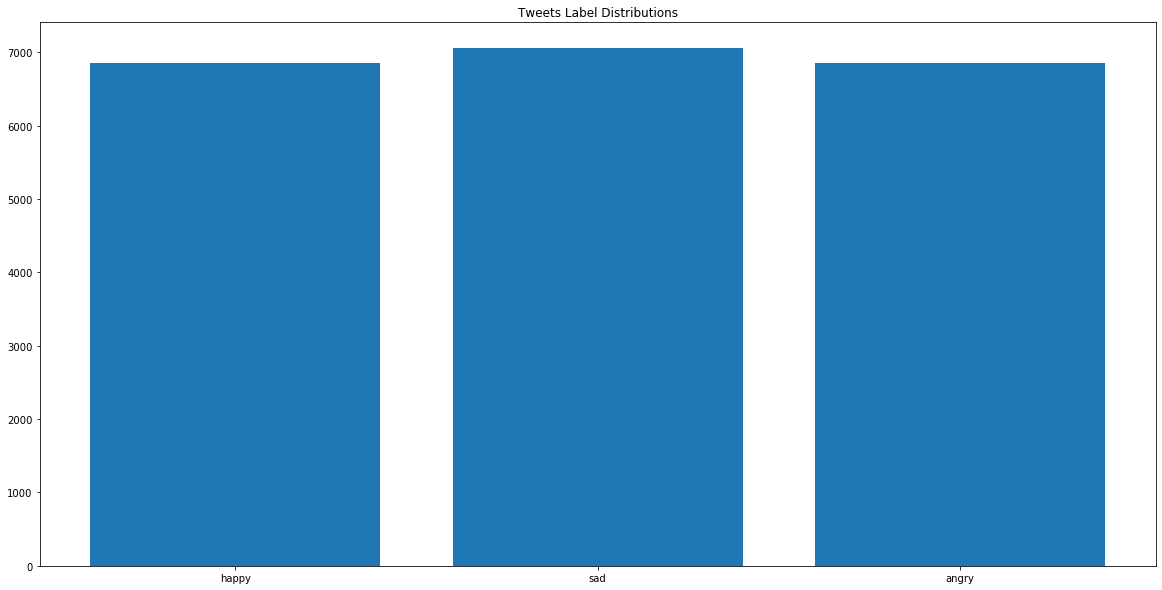

In [13]:
label_count = Counter(finalDF.label)

plt.figure(figsize=(20, 10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Tweets Label Distributions')

### Preprocess Dataset

In [14]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [15]:
def preprocess(text, stem=False):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [16]:
%%time
finalDF.text = finalDF.text.apply(lambda x: preprocess(x))

Wall time: 628 ms


In [17]:
finalDF.iloc[0][0]

'brilliant euphoric simply adrift'

### Train, Test set split

In [18]:
X_train, X_test = train_test_split(finalDF, test_size=0.2, random_state=42)

In [19]:
X_train.head()

,text,label
26389,carlson cut hurt,sad
3236,sad realdonaldtrump faketweets wall built vict...,happy
33468,happy birthday one third hot tempered triad th...,angry
33958,robbie henshaw doubt ireland world cup opener ...,angry
28974,heated argument takes cut lives short place ad...,angry


In [20]:
%%time
documents = [_text.split() for _text in X_train.text]

Wall time: 32.8 ms


In [21]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300,
                                            window=7,
                                           min_count=10,
                                           workers=8)

In [22]:
%%time
w2v_model.build_vocab(documents)

Wall time: 569 ms


In [23]:
words = w2v_model.wv.vocab.keys()
vocab_size=len(words)
print("Vocab size:", vocab_size)

Vocab size: 2523


In [24]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

Wall time: 3.46 s


(3249894, 5083872)

In [25]:
# Check for similar words
w2v_model.most_similar("happy")

[('wishing', 0.6434803009033203),
 ('tuesday', 0.6291260719299316),
 ('birthday', 0.6160398125648499),
 ('everyday', 0.5965734720230103),
 ('bday', 0.5916093587875366),
 ('minister', 0.5658792853355408),
 ('cheerful', 0.5623328685760498),
 ('energy', 0.5134850740432739),
 ('wishes', 0.5086249709129333),
 ('peaceful', 0.5072087049484253)]

### Tokenize Text

In [26]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 28471
Wall time: 365 ms


In [27]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test.text), maxlen=300)

Wall time: 389 ms


In [28]:
labels = finalDF.label.unique().tolist()
labels

['happy', 'sad', 'angry']

In [29]:
encoder = LabelEncoder()
encoder.fit(X_train.label.tolist())

y_train = encoder.transform(X_train.label.tolist())
y_test = encoder.transform(X_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train_labels = to_categorical(y_train, num_classes=3)
y_test_labels = to_categorical(y_test, num_classes=3)

y_train (16616, 1)
y_test (4155, 1)


4155

In [30]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (16616, 300)
y_train (16616, 1)

x_test (4155, 300)
y_test (4155, 1)


In [31]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(28471, 300)


In [32]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [33]:
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(8, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(16, 5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv1D(16, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(32, 5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv1D(32, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
    return model

In [34]:
model = create_model()
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          8541300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 8)            12008     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 148, 8)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 144, 16)           656       
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 140, 16)           1296      
_____________________

In [35]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [36]:
%%time
history = model.fit(x_train, y_train_labels,
                    batch_size=32,
                    epochs=25,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 14954 samples, validate on 1662 samples
Epoch 1/5
14954/14954 [==============================] - 281s 19ms/step - loss: 0.9652 - acc: 0.4626 - val_loss: 0.8459 - val_acc: 0.5361
Epoch 2/5
14954/14954 [==============================] - 271s 18ms/step - loss: 0.8280 - acc: 0.5370 - val_loss: 0.7742 - val_acc: 0.5752
Epoch 3/5
14954/14954 [==============================] - 308s 21ms/step - loss: 0.7473 - acc: 0.6376 - val_loss: 0.6557 - val_acc: 0.7286
Epoch 4/5
14954/14954 [==============================] - 331s 22ms/step - loss: 0.6769 - acc: 0.7164 - val_loss: 0.6408 - val_acc: 0.7280
Epoch 5/5
14954/14954 [==============================] - 320s 21ms/step - loss: 0.6509 - acc: 0.7336 - val_loss: 0.6344 - val_acc: 0.7323
Wall time: 25min 18s


In [37]:
%%time
score = model.evaluate(x_test, y_test_labels, batch_size=32)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4155/4155 [==============================] - 14s 3ms/step

ACCURACY: 0.738628158930837
LOSS: 0.6407173018880126
Wall time: 13.6 s


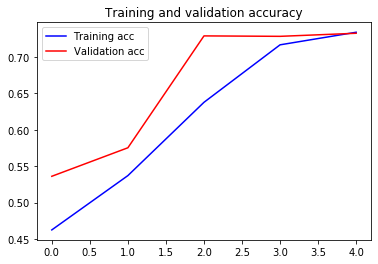

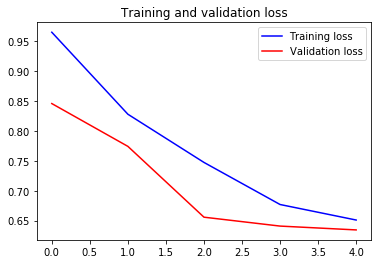

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [47]:
def decode_sentiment(score):    
    label = 'HAPPY'
    if score <= 0.3:
        label = 'SAD'
    elif score > 0.3 and score < 0.7:
        label = 'ANGRY'
    return label

In [78]:
X_test_onehot = OneHotEncoder().fit_transform(X_test['label'])

ValueError: Expected 2D array, got 1D array instead:
array=['sad' 'sad' 'happy' ... 'sad' 'happy' 'sad'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [79]:
def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])
    print(score)
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score)}  

In [80]:
predict('I love you!')

[[0.16226925 0.18705487 0.6506759 ]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [53]:
%%time
y_pred_1d = []
y_test_1d = list(X_test['label'])
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[4155,8,1,296] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1d_1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[dense_2/Softmax/_441]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[4155,8,1,296] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1d_1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [42]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [43]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
# plt.figure(figsize=(12,12))
# plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
# plt.show()

NameError: name 'y_test_1d' is not defined

In [44]:
print(classification_report(y_test_1d, y_pred_1d))

NameError: name 'y_test_1d' is not defined

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)